# **GAN**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)


In [5]:
os.makedirs("samples", exist_ok=True)

epochs = 50
fixed_noise = torch.randn(64, 100, device=device)

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Loss on real images
        outputs = D(real_imgs)
        d_loss_real = criterion(outputs, real_labels)

        # Loss on fake images
        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total loss and update
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # === Train Generator ===
        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)  # Generator wants D to output 1

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # Save sample images
    with torch.no_grad():
        fake_imgs = G(fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake_imgs, nrow=8, normalize=True)
        vutils.save_image(grid, f'samples/epoch_{epoch+1}.png')


Epoch [1/50]  D_loss: 0.1335, G_loss: 4.9796
Epoch [2/50]  D_loss: 0.9289, G_loss: 4.1040
Epoch [3/50]  D_loss: 0.3417, G_loss: 4.0372
Epoch [4/50]  D_loss: 1.2479, G_loss: 1.9562
Epoch [5/50]  D_loss: 1.1104, G_loss: 2.6784
Epoch [6/50]  D_loss: 0.4519, G_loss: 2.3907
Epoch [7/50]  D_loss: 0.1077, G_loss: 3.5192
Epoch [8/50]  D_loss: 0.2279, G_loss: 4.5960
Epoch [9/50]  D_loss: 0.1999, G_loss: 4.0670
Epoch [10/50]  D_loss: 0.1609, G_loss: 5.1340
Epoch [11/50]  D_loss: 0.5053, G_loss: 3.5007
Epoch [12/50]  D_loss: 0.2038, G_loss: 4.7092
Epoch [13/50]  D_loss: 0.1413, G_loss: 6.0864
Epoch [14/50]  D_loss: 0.2761, G_loss: 3.0305
Epoch [15/50]  D_loss: 0.2797, G_loss: 4.1982
Epoch [16/50]  D_loss: 0.2426, G_loss: 6.1731
Epoch [17/50]  D_loss: 0.3259, G_loss: 6.8094
Epoch [18/50]  D_loss: 0.4057, G_loss: 4.7743
Epoch [19/50]  D_loss: 0.1563, G_loss: 3.8241
Epoch [20/50]  D_loss: 0.1713, G_loss: 4.6133
Epoch [21/50]  D_loss: 0.1212, G_loss: 6.4931
Epoch [22/50]  D_loss: 0.1712, G_loss: 4.39

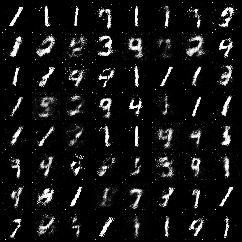

In [6]:
from PIL import Image
from IPython.display import display

img = Image.open("samples/epoch_50.png")
display(img)


# **ALEXNET**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [8]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match original AlexNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
epochs = 5  # You can increase for better accuracy

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 100] loss: 2.168
[1, 200] loss: 1.840
[1, 300] loss: 1.753
[1, 400] loss: 1.667
[1, 500] loss: 1.581
[1, 600] loss: 1.551
[1, 700] loss: 1.495
[2, 100] loss: 1.405
[2, 200] loss: 1.387
[2, 300] loss: 1.390
[2, 400] loss: 1.337
[2, 500] loss: 1.330
[2, 600] loss: 1.330
[2, 700] loss: 1.292
[3, 100] loss: 1.258
[3, 200] loss: 1.204
[3, 300] loss: 1.185
[3, 400] loss: 1.180
[3, 500] loss: 1.175
[3, 600] loss: 1.191
[3, 700] loss: 1.147
[4, 100] loss: 1.141
[4, 200] loss: 1.067
[4, 300] loss: 1.099
[4, 400] loss: 1.097
[4, 500] loss: 1.057
[4, 600] loss: 1.112
[4, 700] loss: 1.073
[5, 100] loss: 1.065
[5, 200] loss: 0.994
[5, 300] loss: 1.014
[5, 400] loss: 1.030
[5, 500] loss: 1.021
[5, 600] loss: 1.030
[5, 700] loss: 1.045
Finished Training


In [12]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10000 test images: {100 * correct / total:.2f}%")


Accuracy on 10000 test images: 65.38%


# **AUTOENCODERS**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [14]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # Latent space (3 features)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    for data, _ in train_loader:
        img = data.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0529
Epoch [2/10], Loss: 0.0412
Epoch [3/10], Loss: 0.0383
Epoch [4/10], Loss: 0.0378
Epoch [5/10], Loss: 0.0315
Epoch [6/10], Loss: 0.0369
Epoch [7/10], Loss: 0.0337
Epoch [8/10], Loss: 0.0366
Epoch [9/10], Loss: 0.0324
Epoch [10/10], Loss: 0.0358


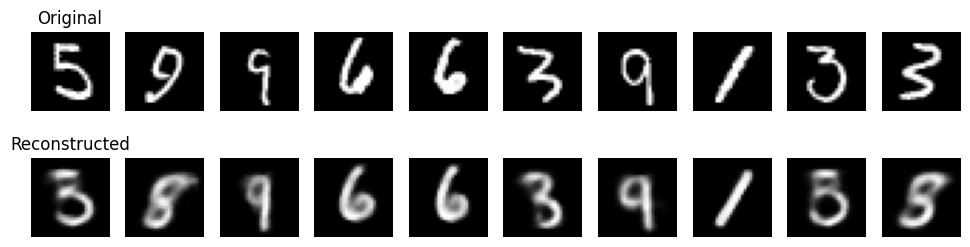

In [18]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for batch in train_loader:
        imgs, _ = batch
        imgs = imgs.to(device)
        outputs = model(imgs)
        break

# Plot original and reconstructed
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axes[0][i].imshow(imgs[i].cpu().squeeze(), cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
    axes[1][i].axis('off')

axes[0][0].set_title("Original")
axes[1][0].set_title("Reconstructed")
plt.show()


# **AUTODECODERS**

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [20]:
# Let's say each shape has 100 3D points
num_shapes = 5
points_per_shape = 100

# Random points and their SDF values (just dummy for demo)
shapes = [torch.randn(points_per_shape, 3) for _ in range(num_shapes)]
sdfs = [torch.randn(points_per_shape, 1) for _ in range(num_shapes)]


In [21]:
class AutoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoDecoder, self).__init__()
        self.latent_dim = latent_dim

        # Decoder MLP: input = [latent vector + 3D coordinate]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Latent codes for each shape (learned!)
        self.latent_codes = nn.Parameter(torch.randn(num_shapes, latent_dim))

    def forward(self, shape_id, coords):
        latent = self.latent_codes[shape_id].unsqueeze(0).expand(coords.shape[0], -1)
        input_vec = torch.cat([latent, coords], dim=1)
        return self.decoder(input_vec)


In [22]:
model = AutoDecoder(latent_dim=16)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(500):
    total_loss = 0
    for i in range(num_shapes):
        coords = shapes[i]
        sdf_values = sdfs[i]

        optimizer.zero_grad()
        output = model(i, coords)
        loss = criterion(output, sdf_values)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 0, Loss: 4.4719
Epoch 50, Loss: 3.3932
Epoch 100, Loss: 2.8224
Epoch 150, Loss: 2.5353
Epoch 200, Loss: 2.1783
Epoch 250, Loss: 1.9367
Epoch 300, Loss: 1.8278
Epoch 350, Loss: 1.5605
Epoch 400, Loss: 1.4816
Epoch 450, Loss: 1.4735


BOLTZMAN MACHINE

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [28]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


In [29]:
class RBM(nn.Module):
    def __init__(self, n_visible=784, n_hidden=128):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))  # hidden layer bias
        self.v_bias = nn.Parameter(torch.zeros(n_visible))  # visible layer bias

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h, self.sample_from_p(p_h)

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v, self.sample_from_p(p_v)

    def forward(self, v):
        # One step contrastive divergence
        p_h, h = self.v_to_h(v)
        p_v, v_sample = self.h_to_v(h)
        return v, v_sample

    def contrastive_divergence(self, v, lr=0.01):
        p_h, h = self.v_to_h(v)
        p_v, v_sample = self.h_to_v(h)
        p_h1, h1 = self.v_to_h(v_sample)

        # Update weights and biases
        self.W.data += lr * (torch.matmul(h.t(), v) - torch.matmul(h1.t(), v_sample)) / v.size(0)
        self.v_bias.data += lr * torch.sum(v - v_sample, dim=0) / v.size(0)
        self.h_bias.data += lr * torch.sum(p_h - p_h1, dim=0) / v.size(0)


In [30]:
rbm = RBM(n_visible=784, n_hidden=128)
epochs = 5
lr = 0.01

for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784)
        batch = (batch > 0.5).float()  # Binarize the input
        v0, vk = rbm(batch)
        loss = torch.mean((v0 - vk) ** 2)
        rbm.contrastive_divergence(batch, lr)
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 158.7448
Epoch 2, Loss: 112.3743
Epoch 3, Loss: 100.2381
Epoch 4, Loss: 92.5342
Epoch 5, Loss: 87.2320


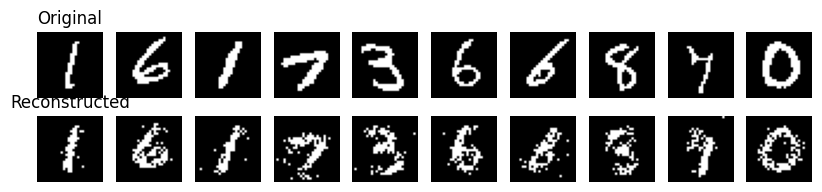

In [31]:
def show_reconstruction(rbm, data_loader):
    for batch, _ in data_loader:
        batch = batch.view(-1, 784)
        batch = (batch > 0.5).float()
        v, v_reconstructed = rbm(batch)
        break

    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0][i].imshow(v[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[1][i].imshow(v_reconstructed[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[0][i].axis('off')
        axes[1][i].axis('off')
    axes[0][0].set_title("Original")
    axes[1][0].set_title("Reconstructed")
    plt.show()

show_reconstruction(rbm, train_loader)
